In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time as time
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(1, module_path + '/src')
import utility
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sktime.transformations.panel.rocket import Rocket
from sklearn import preprocessing
import time
from sktime.transformations.panel.rocket import MiniRocket
from sktime.utils.data_processing import from_nested_to_2d_array

colors = ['#00a260', '#61b35f', '#96c362', '#c6d26d', '#f4e07f', '#f0bc55', '#ec9533', '#e86a20', '#e0301e']
class_names = ['crackle', 'no-crackle']


def get_initial_classifier(X_train_full,y_train_full, clf, grid, no_grid_search = False):
    grid_cv=GridSearchCV(clf,grid,cv=2)
    grid_cv.fit(X_train_full,y_train_full)
    return grid_cv.best_estimator_

def get_helping_classifier(X_train, y_train, X_val, y_val, clf, grid = None):
    '''Get the helping classifier
    
    returns a classifier, which classifies if something is likely to be classified wrongly
    
    '''
    new_X = X_val

   
    grid_cv=GridSearchCV(clf,grid,cv=2)
    grid_cv.fit(X_train,y_train)
    clf_2 = grid_cv.best_estimator_
        
    y_pred = clf_2.predict(X_val)
    new_y = pd.Series(np.hstack([y_pred != y_val]))
    
    
    if 'True' not in list(new_y.astype(str)):
        print('Warning, the fold performed perfectly, hence there is no errors to train the heliping classifier on.')
        print('No subhelper is passed to the ensemble')
        return None, None
    
    
    grid_cv=GridSearchCV(clf,grid,cv=2)
    grid_cv.fit(new_X,new_y)
    return grid_cv.best_estimator_ , grid_cv.best_score_


def get_ensemble_helping_classifier(X_full, y_full, clf, grid):
    kf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
    print(X_full)
    classifiers = []
    for train_index, val_index in kf.split(X_full, y_full):
        clf_temp, score_temp = get_helping_classifier(X_full.iloc[train_index], y_full.iloc[train_index], X_full.iloc[val_index], y_full.iloc[val_index], clf, grid)
        if clf_temp == None:
            continue
        classifiers.append((clf_temp, score_temp))
    return classifiers

def make_ensemble_classification(X_test, ensemble):
    y_pred = []
    for e in ensemble: 
        clf = e[0]
        score = e[1]
        y_pred_temp = clf.predict(X_test)
        y_pred.append((score * (y_pred_temp + 1)) -1)
    y_pred = np.array(y_pred)
    y_pred_sum = y_pred.sum(axis = 0)
    idx_true = np.where(y_pred_sum > 0)[0]
    
    y_pred = y_pred.mean(axis = 0)
    y_pred = np.round(y_pred).astype(int)
    
    y_pred[idx_true] = 1
    return y_pred

def filter_test_set_ensemble(X_test, y_test, ensemble):
    y_pred = make_ensemble_classification(X_test, ensemble)
    to_del = np.where(y_pred == 1)[0]
    print('Indices to delete: ')
    print(to_del)
    X_test = X_test.reset_index(drop = True)
    y_test = y_test.reset_index(drop = True)
    X_test_new = X_test[~X_test.index.isin(to_del)]
    y_test_new = y_test[~y_test.index.isin(to_del)]
    return X_test_new, y_test_new

In [2]:
start = time.time()
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_MiniROCKET_TRAIN.ts')
print('Time to fetch X y: ', time.time() - start)

Time to fetch X y:  38.48074984550476


In [3]:
start = time.time()
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_MiniROCKET_TEST.ts')
print('Time to fetch X y: ', time.time() - start)

Time to fetch X y:  12.623598575592041


Converting the training and testing samples to the right format

In [4]:
X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))

X_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995
0,0.27215,0.89890,0.04315,0.27215,0.98700,0.18545,0.72075,0.00565,0.27215,0.94460,...,0.66490,0.0,0.0,1.000,0.39455,0.60950,0.92465,1.00,1.000,1.0
1,0.33040,0.85205,0.10535,0.33040,0.92905,0.18745,0.76150,0.04545,0.33040,0.87885,...,0.72680,0.0,0.0,1.000,0.32770,0.69565,0.97335,0.00,1.000,0.0
2,0.36975,0.88565,0.03390,0.36975,0.98830,0.22495,0.69485,0.00505,0.36975,0.94615,...,0.86065,0.0,1.0,1.000,0.16340,0.73385,0.98935,0.25,1.000,0.0
3,0.29945,0.89450,0.04925,0.29945,0.97270,0.18120,0.75525,0.01795,0.29945,0.93485,...,0.90720,0.0,0.0,1.000,0.11240,0.78605,0.99120,0.00,1.000,0.0
4,0.28915,0.88450,0.04765,0.28915,0.98020,0.19345,0.75700,0.00930,0.28915,0.93520,...,0.80255,0.0,0.0,0.000,0.22360,0.72400,0.98955,0.00,0.250,0.0
5,0.43560,0.86820,0.03415,0.43560,0.99040,0.26350,0.63740,0.00365,0.43560,0.93925,...,0.64265,0.0,0.0,0.250,0.36440,0.47440,0.77410,0.00,1.000,0.0
6,0.20130,0.95060,0.01600,0.20130,0.99125,0.10835,0.84660,0.00405,0.20130,0.97420,...,0.69475,0.0,0.0,0.375,0.33125,0.62475,0.96105,0.00,1.000,0.0
7,0.38535,0.86240,0.05140,0.38535,0.97570,0.24730,0.68850,0.01280,0.38535,0.92495,...,0.78935,0.0,1.0,1.000,0.23510,0.66310,0.97505,0.00,1.000,0.0
8,0.23825,0.82740,0.10455,0.23825,0.94385,0.20000,0.77535,0.03275,0.23825,0.86805,...,0.66310,0.0,0.0,1.000,0.34390,0.59135,0.90770,0.00,1.000,0.0
9,0.41750,0.88545,0.06355,0.41750,0.96960,0.22905,0.69230,0.01545,0.41750,0.92975,...,0.87495,0.0,0.0,1.000,0.12940,0.76010,0.99670,0.00,0.625,0.0


## Running simple feature selection

An alternative approach is to firstly do some filtering based on statistics, then move on to an autoencoder approach 

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

k = 100
select = SelectKBest(chi2, k=k)
X_train_s = select.fit(X_train, y_train)
indices = select.get_support(indices = True)
X_test_s = X_test[indices]
X_train_s = X_train[indices]

scaler = MinMaxScaler()
scaler.fit(X_train_s)
X_train_norm = scaler.transform(X_train_s)
X_test_norm = scaler.transform(X_test_s)

print(X_train_s.shape)
X_train_s.head(10)

(4998, 100)


,256,259,277,298,324,458,492,497,500,518,...,3539,3568,3573,3785,3861,3869,4196,4199,4534,4869
0,0.116397,0.267507,0.254602,0.19345,0.207083,0.17700,0.238295,0.192527,0.264706,0.191176,...,0.206240,0.214630,0.14225,0.14635,0.181109,0.122031,0.10760,0.24255,0.102718,0.14820
1,0.210484,0.304122,0.307673,0.23465,0.215186,0.27020,0.304172,0.278912,0.316226,0.256653,...,0.174136,0.196744,0.15315,0.13055,0.200533,0.127566,0.15830,0.22630,0.131063,0.14370
2,0.199630,0.332783,0.329482,0.25080,0.249050,0.27050,0.260054,0.189526,0.302321,0.254152,...,0.215082,0.243871,0.15885,0.13270,0.244213,0.109400,0.15185,0.29255,0.110348,0.14840
3,0.210484,0.283063,0.285164,0.23135,0.223139,0.26070,0.260654,0.238395,0.275210,0.251150,...,0.131230,0.142283,0.06155,0.04995,0.169233,0.039704,0.07450,0.20155,0.044008,0.05360
4,0.184774,0.268507,0.268858,0.21430,0.210034,0.23415,0.250000,0.220988,0.264606,0.233393,...,0.187600,0.213776,0.15640,0.13430,0.215529,0.122685,0.16360,0.25330,0.135661,0.14945
5,0.166216,0.367747,0.356643,0.26280,0.278361,0.25145,0.212635,0.125550,0.285364,0.222539,...,0.257687,0.294011,0.20370,0.20710,0.259410,0.171246,0.16315,0.32800,0.162338,0.20905
6,0.031863,0.142557,0.138705,0.09670,0.109894,0.06455,0.144458,0.106443,0.165666,0.064076,...,0.103798,0.090786,0.04410,0.03960,0.080163,0.039503,0.03945,0.11325,0.029305,0.04435
7,0.201080,0.349690,0.345338,0.26020,0.250550,0.28180,0.338886,0.307423,0.356243,0.281463,...,0.235782,0.285973,0.20985,0.20235,0.265197,0.173259,0.19665,0.32525,0.173555,0.23215
8,0.185724,0.229242,0.229892,0.20785,0.209434,0.20770,0.219338,0.200980,0.228741,0.208733,...,0.208099,0.219102,0.18960,0.18840,0.211755,0.178442,0.18015,0.22725,0.168351,0.19745
9,0.197679,0.370348,0.362745,0.24735,0.239796,0.27610,0.282413,0.211685,0.329632,0.248099,...,0.210661,0.251859,0.16055,0.11695,0.263537,0.117401,0.18545,0.32520,0.124697,0.12720


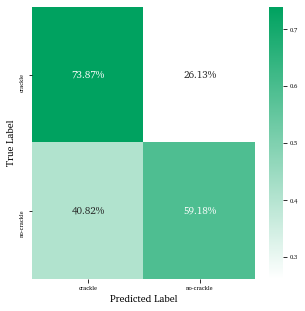

In [7]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1).fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)
utility.plot_cm(y_test, y_pred,module_path = module_path)

# Testing out classification approaches

### Problibalistic approach : Gaussian process

In [6]:
'''

# grid search kernel for gaussian process classifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

# define model
model = GaussianProcessClassifier()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

start = time.time()
# perform the search
results = search.fit(X_train_s, y_train)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))
print('Time to do hyperparameter search: ', time.time() - start)


'''

'\n\n# grid search kernel for gaussian process classifier\nfrom sklearn.datasets import make_classification\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.gaussian_process import GaussianProcessClassifier\nfrom sklearn.gaussian_process.kernels import RBF\nfrom sklearn.gaussian_process.kernels import DotProduct\nfrom sklearn.gaussian_process.kernels import Matern\nfrom sklearn.gaussian_process.kernels import RationalQuadratic\nfrom sklearn.gaussian_process.kernels import WhiteKernel\n\n# define model\nmodel = GaussianProcessClassifier()\n# define model evaluation method\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\n# define grid\ngrid = dict()\ngrid[\'kernel\'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]\n# define search\nsearch = GridSearchCV(model, grid, scoring=\'accuracy\', cv=cv, n_jobs=-1)\n\nstart = time.time()\n# perform the search\nresult

In [7]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train_s ,y_train)

Getting the prediction vector

In [8]:
y_pred = gpc.predict(X_test_s)

Getting the prediction probabilities

In [9]:
p = gpc.predict_proba(X_test_s)

## Exploring the prediction results

In [10]:
results = {
    'true': y_test.tolist(),
    'pred': y_pred.tolist(),
    'prob no crackle' : p[:,0].tolist(),
    'prob crackle' : p[:,1].tolist(),
}
result_df = pd.DataFrame(data = results)

i_true = np.where((result_df['true'] != result_df['pred']) == True)
i_false = np.where((result_df['true'] != result_df['pred']) == False)
new_pred = np.where(((result_df['prob no crackle'] < 0.65) & (result_df['prob no crackle'] > 0.5) ) == True)
new_pred_2 = np.where(((result_df['prob crackle'] < 0.65) & (result_df['prob crackle'] > 0.5) ) == True)
t = np.concatenate((new_pred, new_pred_2), axis = 1)[0]
result_df_filtered = result_df.drop(t, axis = 0)
new_y_test = result_df_filtered['true'].values
new_y_pred = result_df_filtered['pred'].values

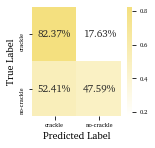

In [11]:
utility.plot_cm(y_test, y_pred, hex_color_str = colors[4])

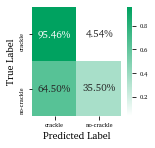

In [12]:
utility.plot_cm(new_y_test, new_y_pred, hex_color_str = colors[0])

In [13]:
result_df.iloc[i_true]

,true,pred,prob no crackle,prob crackle
1,1,0,0.523847,0.476153
10,0,1,0.490958,0.509042
11,1,0,0.505197,0.494803
12,1,0,0.708496,0.291504
13,0,1,0.432900,0.567100
...,...,...,...,...
1638,1,0,0.512945,0.487055
1640,0,1,0.451334,0.548666
1657,1,0,0.580742,0.419258
1660,1,0,0.511794,0.488206


In [14]:
result_df.iloc[i_false]

,true,pred,prob no crackle,prob crackle
0,0,0,0.847014,0.152986
2,0,0,0.930170,0.069830
3,0,0,0.615599,0.384401
4,0,0,0.644488,0.355512
5,0,0,0.535007,0.464993
...,...,...,...,...
1661,0,0,0.790527,0.209473
1662,1,1,0.461938,0.538062
1663,0,0,0.570875,0.429125
1664,1,1,0.299483,0.700517


## Ensemble double classifier code

nb! 

This code takes a long time, and had some errors. Will need debugging

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle

a_file = open(module_path + '/src/dictionaries/empty_temp_dict.pkl', 'rb')
temp_dict = pickle.load(a_file)

max_nn = round((0.8*X.shape[0])//8)
k_range = list(range(1,max_nn))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)
clf = KNeighborsClassifier()

clf_full = get_initial_classifier(X_train_s, y_train, clf, grid)
temp_dict['KNN']['init'] = clf_full
clf_ensemble = get_ensemble_helping_classifier(X_train_s, y_train, clf, grid)
temp_dict['KNN']['ensemble'] = clf_ensemble

############ Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
clf=LogisticRegression()

clf_full = get_initial_classifier(X_train_s, y_train, clf, grid)
temp_dict['LR']['init'] = clf_full
clf_ensemble = get_ensemble_helping_classifier(X_train_s, y_train, clf, grid)
temp_dict['LR']['ensemble'] = clf_ensemble


############ SVM
grid = {'C': [0.1, 1, 10, 100, 1000],  
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
          'kernel': ['rbf']}  
clf = SVC()

clf_full = get_initial_classifier(X_train_s, y_train, clf, grid)
temp_dict['SVM']['init'] = clf_full
clf_ensemble = get_ensemble_helping_classifier(X_train_s, y_train, clf, grid)
temp_dict['SVM']['ensemble'] = clf_ensemble

############# Random Forest
grid = {
'n_estimators'      : [100,200,300],
'max_depth'         : [8, 10, 12],
'random_state'      : [0],
}
clf = RandomForestClassifier()

clf_full = get_initial_classifier(X_train_s, y_train, clf, grid)
temp_dict['RF']['init'] = clf_full
clf_ensemble = get_ensemble_helping_classifier(X_train_s, y_train, clf, grid)
temp_dict['RF']['ensemble'] = clf_ensemble


          206       259       280       285      298      458      466   \
0     0.143758  0.079032  0.229692  0.047719  0.10795  0.05295  0.09460   
1     0.253651  0.243748  0.314826  0.241897  0.24340  0.24780  0.27710   
2     0.285764  0.259904  0.341837  0.229942  0.26940  0.24075  0.28570   
3     0.256252  0.247649  0.293567  0.248800  0.24935  0.25355  0.26945   
4     0.230242  0.218087  0.272809  0.202181  0.21895  0.20850  0.23660   
...        ...       ...       ...       ...      ...      ...      ...   
4993  0.167017  0.154562  0.192727  0.162215  0.16170  0.16620  0.17800   
4994  0.041617  0.016557  0.077181  0.006303  0.03520  0.00765  0.02190   
4995  0.194228  0.194228  0.212785  0.191277  0.19005  0.19370  0.20085   
4996  0.210684  0.172419  0.260854  0.140106  0.19535  0.15325  0.19785   
4997  0.273259  0.253101  0.302921  0.238846  0.25405  0.24250  0.27105   

          494      625      633   ...     3573     3777      3861      3908  \
0     0.116997  0.17

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

clf.fit(X_train_s, y_train) 
y_pred = clf.predict(X_test_s)

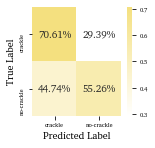

In [18]:
utility.plot_cm(y_test, y_pred, hex_color_str = colors[4])